In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models

from datetime import datetime
import cv2

In [5]:
train_set = datasets.CIFAR10(root='cifardata', train=True, download=True)
valid_set = datasets.CIFAR10(root='cifardata', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
x, y = train_set[200]
y

6

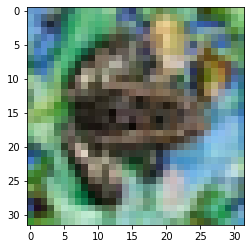

In [22]:
plt.imshow(x);

In [23]:
x = np.array(x)
pad = 4
x = cv2.copyMakeBorder(x, pad, pad, pad, pad, cv2.BORDER_REFLECT)

(40, 40, 3)

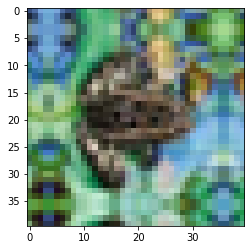

In [24]:
plt.imshow(x)
x.shape

In [25]:
from imgaug import augmenters as iaa

In [28]:
seq = iaa.Sequential([
    iaa.Flipud(0.5),
    #iaa.GaussianBlur(.7),
    #iaa.AdditiveGaussianNoise(scale=(0, 30)),
    #iaa.pillike.FilterEdgeEnhanceMore(),
    iaa.Crop(percent=(0., 0.2))
])

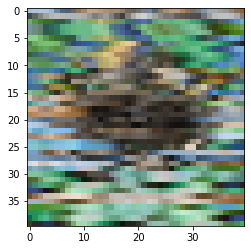

In [29]:
img_aug = seq(images = x)
plt.imshow(img_aug);

In [30]:
xlist = []
label = []
pad = 4
for i in train_set:
    x,y = i
    x = np.array(x)
    x = cv2.copyMakeBorder(x, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    xlist.append(x)
    label.append(y)

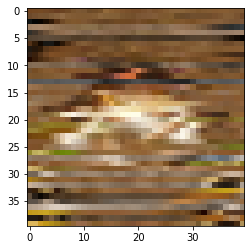

In [32]:
plt.imshow(seq(images = xlist[0]));

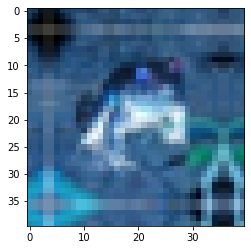

In [52]:
plt.imshow(cv2.cvtColor(xlist[0], cv2.COLOR_BGR2RGB))

In [41]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [45]:
def resize_crop_image(xlist,sz=(303, 227)):
    #im = read_image(path)
    im = center_crop(xlist)
    return cv2.resize(im, sz)

In [46]:
resize_crop_image(xlist)

AttributeError: 'list' object has no attribute 'shape'

In [34]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [38]:
normalize(xlist[0])

array([[[460.76419214, 279.21428571, 122.64      ],
        [377.79475983, 239.03571429, 109.30666667],
        [163.8209607 ,  87.25      ,  15.97333333],
        ...,
        [526.26637555, 377.42857143, 211.52888889],
        [543.73362445, 386.35714286, 220.41777778],
        [565.56768559, 399.75      , 220.41777778]],

       [[360.32751092, 221.17857143, 100.41777778],
        [211.8558952 , 118.5       ,  33.75111111],
        [ 67.7510917 ,  29.21428571,  -1.80444444],
        ...,
        [521.89956332, 372.96428571, 220.41777778],
        [513.16593886, 372.96428571, 220.41777778],
        [565.56768559, 417.60714286, 255.97333333]],

       [[220.58951965, 118.5       ,  33.75111111],
        [ 76.48471616,  33.67857143,  -1.80444444],
        [ -2.11790393,  -2.03571429,  -1.80444444],
        ...,
        [517.53275109, 368.5       , 220.41777778],
        [535.        , 390.82142857, 242.64      ],
        [578.66812227, 426.53571429, 264.86222222]],

       ...,

      

In [35]:
class InvasiveDataset(Dataset):
    def __init__(self, labels, transform=False):
        self.num_files = len(labels)
        #self.files_path = files_path
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        row = self.labels.iloc[index,:]
        y = row["invasive"]
        file_name = str(row["name"]) + ".jpg"
        #path = self.files_path/file_name
        #x = read_image(path)
        # if self.transform:
        #     rdeg = (np.random.random()-.50)*20
        #     x = rotate_cv(x, rdeg)
        #     x = random_crop(x)
        #     if np.random.random() > 0.5: x = np.fliplr(x).copy()
        # else:
        #     x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2), y[None]

In [40]:
test = normalize(xlist[0])
np.rollaxis(test,2).shape

(3, 40, 40)

In [ ]:
train_ds = InvasiveDataset(PATH/"train_303_227", labels=train_labels, transform=True)
valid_ds = InvasiveDataset(PATH/"train_303_227", labels=valid_labels)